## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [519]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [520]:
#Сразу накидаем функции
def confidence_interval_sigma(n, x_mean, sigma, gamma=0.95):
    """Function to evaluate confidence interval with known true standard deviation

    Args:
        n (int): sample size
        x_mean (int): sample mean
        sigma (int): true standard deviation
        gamma (float): reliability level 0-1

    Returns:
        float: lower_bound, upper_bound
    """
    alpha = 1 - gamma  # уровень значимости

    z_crit = round(-norm.ppf(alpha/2), 2)  # z критическое

    eps = z_crit * sigma/(n ** 0.5)  # погрешность
    lower_bound = round(x_mean - eps, 2)  # левая (нижняя) граница
    upper_bound = round(x_mean + eps, 2)  # правая (верхняя) граница
    # создаём кортеж из округлённых границ интервала
    confidence_interval = (lower_bound, upper_bound)
    # выводим результат
    print(
        f'Доверительный интервал: {lower_bound, upper_bound}, z-крит: {z_crit}')
    return lower_bound, upper_bound, z_crit

def confidence_interval(n, x_mean, x_std, gamma=0.95):
    """_summary_

    Args:
        n (int): sample size
        x_mean (int): sample mean
        x_std (int, float): sample standard deviation
        gamma (float): reliability level 0-1
    """
    k = n - 1  # число степеней свободы
    alpha = 1 - gamma  # уровень значимости

    t_crit = -t.ppf(alpha/2, k)  # t-критическое

    eps = t_crit * x_std/(n ** 0.5)  # погрешность
    lower_bound = round(x_mean - eps, 2)  # левая (нижняя) граница
    upper_bound = round(x_mean + eps, 2)  # правая (верхняя) граница
    # создаём кортеж из округлённых границ интервала
    confidence_interval = (lower_bound, upper_bound)
    #print(
    #    f'Доверительный интервал: {lower_bound, upper_bound}, t-крит: {t_crit}')
    return lower_bound, upper_bound, t_crit

def proportions_conf_interval(n, x_p, gamma=0.95):
    """Function to evaluate confidence interval for proportion and
    true standard deviation.

    Args:
        n (int): sample size
        x_p (int): sample proportion (% of success)
        gamma (float): reliability level 0-1

    Returns:
        float: lower_bound, upper_bound, sigma
    """
    alpha = 1 - gamma  # уровень значимости
    z_crit = -norm.ppf(alpha/2)  # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5  # погрешность
    sigma = round((x_p * (1 - x_p))**0.5, 3) #true standard deviation

    lower_bound = round((x_p - eps)*100, 2)  # левая (нижняя) граница
    upper_bound = round((x_p + eps)*100, 2)  # правая (верхняя) граница

    #print(
    #    f'Доверительный интервал: {lower_bound, upper_bound}, z-крит: {z_crit}, sigma: {sigma}')
    return lower_bound, upper_bound, sigma

def diff_proportions_conf_interval(n, x_p, gamma=0.95):
    """Function to evaluate confidence interval for delta of proportion.

    Args:
        n (list): list of samples sizes (for example: n = [a_data['user_id'].count(), b_data['user_id'].count()])
        x_p (list): list of samples proportions (for example: xp = [a_data['converted'].mean(), b_data['converted'].mean()])
        gamma (float, optional): reliability level 0-1

    Returns:
        float: lower_bound, upper_bound (%)
    """

    alpha = 1 - gamma  # уровень значимости
    diff = x_p[1] - x_p[0]  # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2)  # z критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] *
                    (1 - x_p[1])/n[1]) ** 0.5  # погрешность

    lower_bound = round((diff - eps)*100, 2)  # левая (нижняя) граница
    upper_bound = round((diff + eps)*100, 2)  # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return lower_bound, upper_bound


Прочитаем наши данные и посмотрим на столбцы таблицы:

In [521]:
data = pd.read_csv('../data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


---

## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [522]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Ответ: date имеет тип данных object

---

## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [523]:
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")

In [524]:
print(
    data.groupby('group')[['date']].min(),
    data.groupby('group')[['date']].max())


            date
group           
A     2021-01-02
B     2021-01-02             date
group           
A     2021-01-24
B     2021-01-24


Ответ: 02.01.2021 - 24.01.2021 обе группы тыстировались параллельно

---

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [525]:
count_visits = data.groupby(['group'])[['user_id']].count().reset_index()
purcase_revenue = data.groupby(
    ['group'])[['purchase', 'price']].sum().reset_index()

cons_df = count_visits.merge(purcase_revenue)

cons_df.rename(
    columns={
        'user_id': 'count_visits',
        'purchase': 'count_purchases',
        'price': 'sum_price'
    },
    inplace=True
)
cons_df['sum_price'] = round(cons_df['sum_price']/1000000, 2)

display(cons_df)
print(
    f'Колличество клиентов по группам. A: {cons_df["count_visits"][0]}, B: {cons_df["count_visits"][1]}')
print(
    f'Суммарное количество по группам. A: {cons_df["count_purchases"][0]}, B: {cons_df["count_purchases"][1]}')
print(
    f'Сумма покупок по группам. A: {cons_df["sum_price"][0]}, B: {cons_df["sum_price"][1]}')
print(
    f'Сумма всех покупок в обеих группах составляет {round(cons_df["sum_price"].sum(),2)} млн.руб.')


,group,count_visits,count_purchases,sum_price
0,A,147202,17723,1436.26
1,B,147276,17514,1554.10


Колличество клиентов по группам. A: 147202, B: 147276
Суммарное количество по группам. A: 17723, B: 17514
Сумма покупок по группам. A: 1436.26, B: 1554.1
Сумма всех покупок в обеих группах составляет 2990.36 млн.руб.


---

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [526]:
a_group = set(data.query("group == 'A'")['user_id'])
b_group = set(data.query("group == 'B'")['user_id'])
user_intersection = a_group.intersection(b_group)
print(
    f'В выборке есть клиенты попавшие в обе группы, их количество: {len(user_intersection)}')


В выборке есть клиенты попавшие в обе группы, их количество: 1895


---

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [527]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

---

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

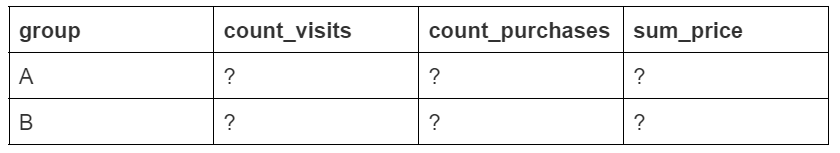
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [528]:
count_visits = updated_data.groupby(
    ['group'])[['user_id']].count().reset_index()
purcase_revenue = updated_data.groupby(
    ['group'])[['purchase', 'price']].sum().reset_index()

cons_df_update = count_visits.merge(purcase_revenue)

cons_df_update.rename(
    columns={
        'user_id': 'count_visits',
        'purchase': 'count_purchases',
        'price': 'sum_price'
    },
    inplace=True
)
cons_df_update['sum_price'] = round(cons_df_update['sum_price']/1000000, 2)

print('Консолидированная таблица без пересечений')
display(cons_df_update)
print(
    f'Колличество посещений по группам. A: {cons_df_update["count_visits"][0]}, B: {cons_df_update["count_visits"][1]}\n')

print('\nСравнительная таблица до и после исключения пересечений')
display(cons_df.compare(cons_df_update).rename(columns={'self':'before','other':'after'}))

print('\nДельта по позициям')
temp_df = cons_df.compare(cons_df_update).diff(axis=1).rename(columns={'self':'before','other':'delta'})
display(temp_df.drop('before', axis=1, level=1))


Консолидированная таблица без пересечений


,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417.78
1,B,145381,17290,1533.01


Колличество посещений по группам. A: 145307, B: 145381


Сравнительная таблица до и после исключения пересечений


count_visits         count_purchases        sum_price         
        before   after          before  after    before    after
0       147202  145307           17723  17487   1436.26  1417.78
1       147276  145381           17514  17290   1554.10  1533.01


Дельта по позициям


,count_visits,count_purchases,sum_price
,delta,delta,delta
0,-1895,-236,-18.48
1,-1895,-224,-21.09


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной страницы, можно ли говорить о сбалансированности выборок?

После проведенной очистки, изменение данных не значительно, распределение клиентов между группами сбалансированно.

---

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [529]:
cons_df_update['conversion'] = round(cons_df_update['count_purchases']/cons_df_update['count_visits']*100,2)
cons_df_update['mean_check'] = round((cons_df_update['sum_price']/cons_df_update['count_purchases'])*1000000)
cons_df_update

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417.78,12.03,81076.0
1,B,145381,17290,1533.01,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

По предварителному анализу можно сказать что вариант лендинга в группе А превосходит вариант в группе В по параметрам:

Превосходство А:
* Количество успешных покупок (не существенно)
* Конверсия (не существенно)

Но при этом вариант В опережает по параметрам:

Превосходство В:
* Общая выручка (существенно)
* Средний чек покупки (существенно)

В данном случае, опираясь на предварительный анализ, можно заключить, что по ключевым метрикам лендинг представленный в варианте В предпочтительнее.


----

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [530]:
pivot_data = updated_data.pivot_table(
    index='group', columns='price', values='purchase', aggfunc='sum')
pivot_data


price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

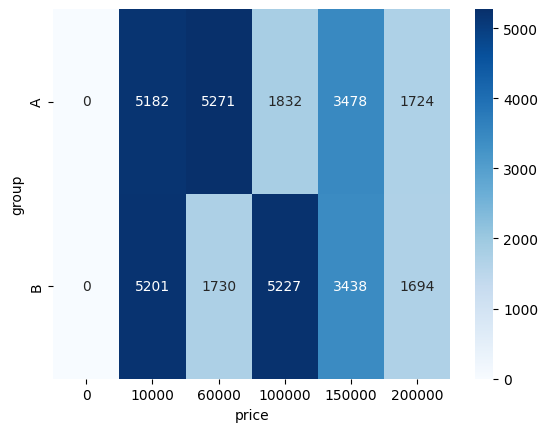

In [531]:
sns.heatmap(pivot_data,annot=True,cmap='Blues',fmt='g');

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Ключевым различием при сравнении групп А и В, является рокировка по численности между двумя ценовыми группами, в целом распределение в обеих группах в разрезе ценового фактора одинаково, но группа А доминирует в ценовом диапазоне 60 000, уступая при этом в диапазоне 100 000, группа В, напротив доминирует в диапазоне 100 000 уступая в 60 000, в разрезе бизнесс метрики лендинг сценария закрепленный за группой В имеет перевес конверсии в более приоритетной группе.

---

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [532]:
updated_data.insert(2,'visits',1) #технический столбец для будущего расчета посещений


In [533]:
data_day_group = updated_data.groupby(['date','group'])[['visits','purchase','price']].sum()  
data_day_group['convertion'] = round(data_day_group['purchase']/data_day_group['visits']*100,2)
data_day_group['avg_check'] = round(data_day_group['price']/data_day_group['purchase'],2)
data_day_group.head()


visits  purchase     price  convertion  avg_check
date       group                                                   
2021-01-02 A        2854       359  29410000       12.58   81922.01
           B        2861       345  29660000       12.06   85971.01
2021-01-03 A        6596       748  62000000       11.34   82887.70
           B        6619       754  65960000       11.39   87480.11
2021-01-04 A        6566       799  64250000       12.17   80413.02

In [534]:
display(data_day_group.query("date == '2021-01-03'")['convertion']) #для ответа на вопросы модуля
display(data_day_group.query("date == '2021-01-03'")['avg_check'].round())

date        group
2021-01-03  A        11.34
            B        11.39
Name: convertion, dtype: float64

date        group
2021-01-03  A        82888.0
            B        87480.0
Name: avg_check, dtype: float64

----

## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [535]:
# добавляем кумулятивные метрики
data_day_group['cum_visits'] = data_day_group.groupby('group')['visits'].cumsum()

data_day_group['cum_purchase'] = data_day_group.groupby('group')['purchase'].cumsum()

data_day_group['cum_price'] = data_day_group.groupby('group')['price'].cumsum()

data_day_group['cum_avg_check'] = data_day_group['cum_price']/data_day_group['cum_purchase']

data_day_group['cum_convertion'] = round(
    data_day_group['cum_purchase']/data_day_group['cum_visits']*100, 2)


display(data_day_group.head(), data_day_group.query("date == '2021-01-20' and group == 'B'")
        ['cum_convertion'], data_day_group.query("date == '2021-01-12' and group =='A'")['cum_avg_check'])

visits  purchase     price  convertion  avg_check  \
date       group                                                      
2021-01-02 A        2854       359  29410000       12.58   81922.01   
           B        2861       345  29660000       12.06   85971.01   
2021-01-03 A        6596       748  62000000       11.34   82887.70   
           B        6619       754  65960000       11.39   87480.11   
2021-01-04 A        6566       799  64250000       12.17   80413.02   

                  cum_visits  cum_purchase  cum_price  cum_avg_check  \
date       group                                                       
2021-01-02 A            2854           359   29410000   81922.005571   
           B            2861           345   29660000   85971.014493   
2021-01-03 A            9450          1107   91410000   82574.525745   
           B            9480          1099   95620000   87006.369427   
2021-01-04 A           16016          1906  155660000   81668.415530   

                  cum_convertion  
date       group                  
2021-01-02 A               12.58  
           B               12.06  
2021-01-03 A               11.71  
           B               11.59  
2021-01-04 A               11.90

date        group
2021-01-20  B        11.9
Name: cum_convertion, dtype: float64

date        group
2021-01-12  A        81491.827275
Name: cum_avg_check, dtype: float64

Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

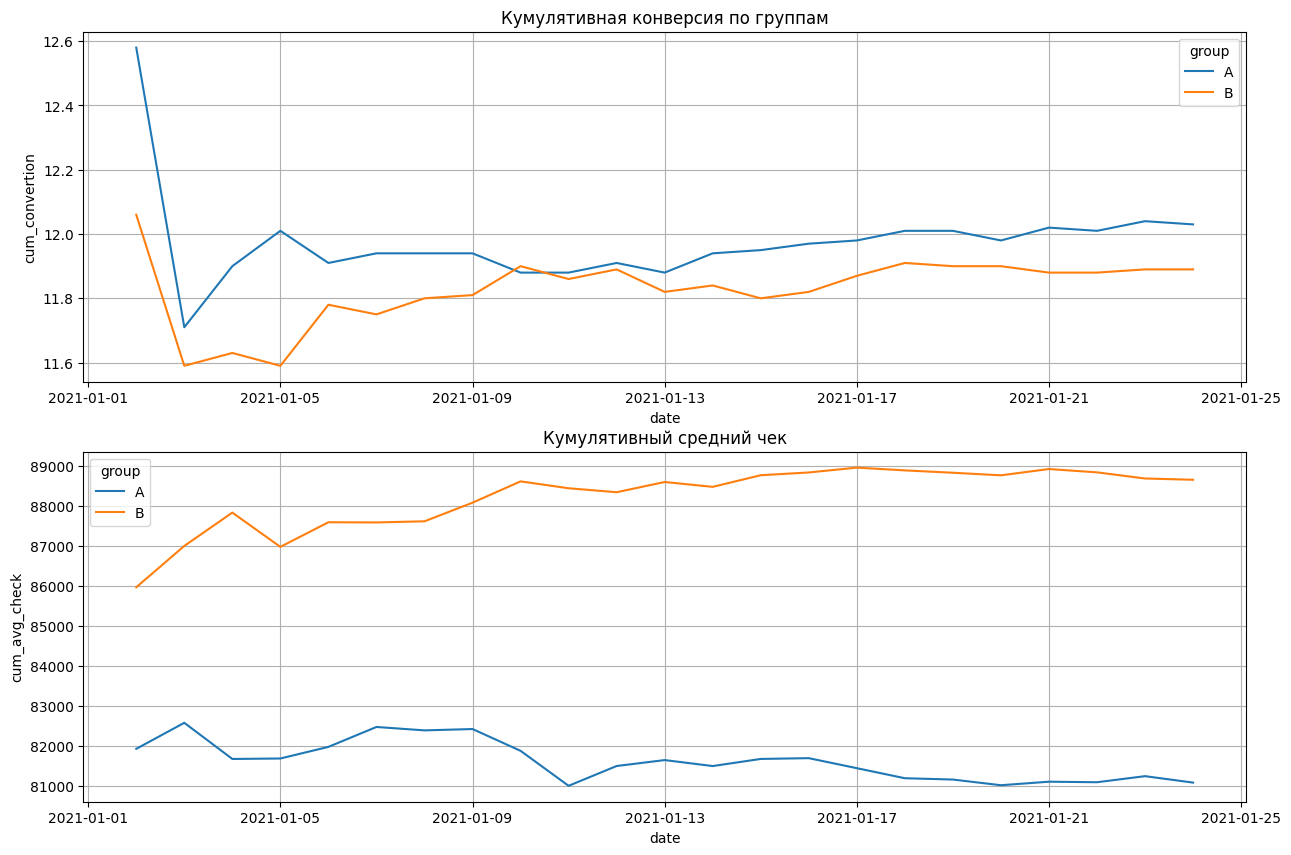

In [536]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

sns.lineplot(
    data=data_day_group,
    x='date',
    y='cum_convertion',
    hue='group',
    ax=axes[0]
)

sns.lineplot(
    data=data_day_group,
    x='date',
    y='cum_avg_check',
    hue='group',
    ax=axes[1]
)

axes[0].set_title('Кумулятивная конверсия по группам')
axes[1].set_title('Кумулятивный средний чек')

axes[0].grid(True)
axes[1].grid(True);

Исходя из графиков стабилизация конверсии произошла после 05.01 до этого момента можно наблюдать аномальное поведение кривых в обеих группах дельта между пиками составляет ~0.5-0.8 пунктов(что в масштабах метрики существенно).

Что касается кумулятивного среднего чека, можно сказать, что окончательно метрика стабилизировалась ~ 10.01, но стоит отметить, что в отличие от кумулятивной конверсии, границы флуктуаций среднего чека более узкие и сами флуктуации не вносят значительного шума в метрику начиная так же с 05.01.

Конверсия по группе А незначительно выше чем группы В, при том кумулятивный средний чек, наоборот выше, и при том значительно, в группе В.
Исходя из этого подтверждается предыдущий вывод дискретного анализа метрик и в случае кумулятивного прироста.

На мой взгляд, для большей достоверности стоило увеличить срок эксперимента с 1 до 2 месяцев, хотя и в данном случае для анализа и выводов по ключевым бизнес метрикам достаточно информации.

----

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [537]:
H0 = 'Конверсии в группах А и B равны.'
H1 = 'Конверсия в группе А больше чем конверсия в группе B.'

alpha = 0.05

test_df = updated_data.groupby('group')['purchase'].agg(['sum', 'count'])
test_df.head()

_, p_value = proportions_ztest(
    count=test_df['sum'],
    nobs=test_df['count'],
    alternative='larger'
)

if alpha > p_value:
    print(H1,f'p_value = {round(p_value,4)}')
else:
    print(H0,f'p_value = {round(p_value,4)}')

Конверсии в группах А и B равны. p_value = 0.1197


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Исходя из результатов z-теста на пропорцию, статистической разницы в конверсии между группами нет.

----

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [538]:
#Расчет доверительного интервала для конверсий по группам
gamma_ = 0.95

#Параметры для группы А
n_a = updated_data.query("group == 'A'")['user_id'].count()
x_p_a = updated_data.query("group == 'A'")['purchase'].mean()
lower_a, upper_a,_ = proportions_conf_interval(n=n_a, x_p=x_p_a, gamma=gamma_)

#Параметры для группы В
n_b = updated_data.query("group == 'B'")['user_id'].count()
x_p_b = updated_data.query("group == 'B'")['purchase'].mean()
lower_b, upper_b,_ = proportions_conf_interval(n=n_b, x_p=x_p_b, gamma=gamma_)

#Расчет доверительного интервала для разницы конверсий
n = [n_a, n_b]
x_p = [x_p_a, x_p_b]
lower, upper = diff_proportions_conf_interval(n=n, x_p=x_p, gamma=gamma_)

print(f'Доверительный интервал для группы А: {lower_a, upper_a}')
print(f'Доверительный интервал для группы А: {lower_b, upper_b}')
print(f'Доверительный интервал для разницы конверсий: {lower, upper}')

Доверительный интервал для группы А: (11.87, 12.2)
Доверительный интервал для группы А: (11.73, 12.06)
Доверительный интервал для разницы конверсий: (-0.38, 0.09)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Исходя из полученных данных можно отметить почти полное перекрытие доверитеотных интервалов групп и отсутствие статистически существенной разницы между конверсиями групп А и В.

---

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [539]:
# Применяем тест Шапиро-Уилка.
alpha = 0.05
H0 = 'Распределение обеих групп нормальное'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

_, p_value_a = shapiro(data_day_group.query("group == 'A'")['avg_check'])
_, p_value_b = shapiro(data_day_group.query("group == 'B'")['avg_check'])

if alpha < p_value_a and alpha < p_value_b:
    print(H0)
else:
    print(H1)


Распределение обеих групп нормальное


---

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [540]:
# Используем независимый t-тест
alpha = 0.05
H0 = 'Ежедневные средние чеки в группах А и B равны'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B'

a = data_day_group.query("group == 'A'")[
    'avg_check']  # массив по среднему чеку А
b = data_day_group.query("group == 'B'")[
    'avg_check']  # массив по среднему чеку В

_, result = ttest_ind(a=a, b=b, alternative='less')

if alpha < result:
    print(H0)
else:
    print(H1)


Ежедневный средний чек в группе А меньше чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

T-test подтвердил ранее выдвинутую гипотезу (основанную на визуальном анализе кумулятивного среднего чека групп) о том что средний чек группы А меньше среднего чека группы В. Исходя из того что данная метрика является одной из ключевых при анализе варианта лендинга, можно заключить, что вариант В- является приоритетным для реализации.

----

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [543]:
#Доверительный интервал для группы А
n_a = data_day_group.query("group == 'A'")['avg_check'].count()
x_mean_a = data_day_group.query("group == 'A'")['avg_check'].mean()
x_std_a = data_day_group.query("group == 'A'")['avg_check'].std()



lower_a, upper_a, _ = confidence_interval(n=n_a, x_mean=x_mean_a, x_std=x_std_a)
print(f'Группа А. Нижняя граница: {round(lower_a)}, верхняя граница: {round(upper_a)}')

#Доверительный интервал для группы В
n_b = data_day_group.query("group == 'B'")['avg_check'].count()
x_mean_b = data_day_group.query("group == 'B'")['avg_check'].mean()
x_std_b = data_day_group.query("group == 'B'")['avg_check'].std()



lower_b, upper_b, _ = confidence_interval(n=n_b, x_mean=x_mean_b, x_std=x_std_b)
print(f'Группа B. Нижняя граница: {round(lower_b)}, верхняя граница: {round(upper_b)}')
print(f'Пересечения: {set([lower_a,upper_a]).intersection(set([lower_b,upper_b]))}')

Группа А. Нижняя граница: 79630, верхняя граница: 82308
Группа B. Нижняя граница: 87626, верхняя граница: 89526
Пересечения: set()


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительные интервалы вероятностного распределения среднего чека для групп А и В сооттветсвуют диапазонам (79 630, 82 308) и (87 626, 89 526) соотвественно. Пересечение распределений отсутсвует. В разрезе бизнес логики лендинг с использованием варианта В является предпочтительным.

----

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Проведенные исследования выявили два момента:
1) Касательно конверсии, тесты показали пересечение интервалов обоих вариантов с отсутствием статистически значимой разницы, что говорит о том, что касательно данной метрики сценарии лендинга не имеют значительной разницы.
2) Касательно оценки среднего чека, сценарий протестированный на группе В показывает значительное превосходство над сценарием А.
Резюмирую можно сказать, что вариант В при его реализации даст прирост среднего чека (и совокупной выручки), но практически не повлияет на конверсию.